In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("MAFood121"))

import cv2
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
from torchvision import datasets, transforms
from glob import glob
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.models import ResNet50_Weights

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42) # try and make the results more reproducible
BASE_PATH = 'MAFood121/'

epochs = 35
batch_size = 64
MICRO_DATA = True # very small subset (just 3 groups)
SAMPLE_TRAINING = False # make train set smaller for faster iteration
IMG_SIZE = (384, 384) # Try to change the model to U-net to avoid the resizing

#Classes of dishes
f = open(BASE_PATH + '/annotations/dishes.txt', "r")
classes = f.read().split('\n')
f.close()
print("***** classes = dishes.txt: ***** " + str(classes))
print("#######################################################################################")

#Ingredients for each class
f = open(BASE_PATH + '/annotations/foodgroups.txt', "r")
ingredients = f.read().split('\n')
f.close()
print("***** ingredients = foodgroups.txt: ***** " + str(classes))
print("#######################################################################################")

#Base Ingredients
f = open(BASE_PATH + '/annotations/baseIngredients.txt', "r")
base_ing = f.read().strip().split(', ')
f.close()
print("***** base_ing = baseIngredients.txt: ***** " + str(classes))
print("#######################################################################################")

#Recovery of annotations ML
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

#train
f = open(BASE_PATH + '/annotations/train.txt', "r")
train_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/train_lbls_ff.txt', "r")
train_labels = f.read().split('\n')
f.close()

#val
f = open(BASE_PATH + '/annotations/val.txt', "r")
val_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/val_lbls_ff.txt', "r")
val_labels = f.read().split('\n')
f.close()

#test
f = open(BASE_PATH + '/annotations/test.txt', "r")
test_images = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/test_lbls_ff.txt', "r")
test_labels = f.read().split('\n')
f.close()

#Recovery of annotations SL
#train
f = open(BASE_PATH + '/annotations/train.txt', "r")
train_imagessl = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/train_lbls_d.txt', "r")
train_labelssl = f.read().split('\n')
f.close()

#val
f = open(BASE_PATH + '/annotations/val.txt', "r")
val_imagessl = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/val_lbls_d.txt', "r")
val_labelssl = f.read().split('\n')
f.close()

#test
f = open(BASE_PATH + '/annotations/test.txt', "r")
test_imagessl = f.read().split('\n')
f.close()
f = open(BASE_PATH + '/annotations/test_lbls_d.txt', "r")
test_labelssl = f.read().split('\n')
f.close()

# Single-Label
train_images_sl = ["MAFood121/images/" + s for s in train_imagessl]
train_df_sl = pd.DataFrame({'path': train_images_sl, 'class_id': train_labelssl})

val_images_sl = ["MAFood121/images/" + s for s in val_imagessl]
val_df_sl = pd.DataFrame({'path': val_images_sl, 'class_id': val_labelssl})

test_images_sl = ["MAFood121/images/" + s for s in test_imagessl]
test_df_sl = pd.DataFrame({'path': test_images_sl, 'class_id': test_labelssl})

# Multi-label
train_images_ml = ["MAFood121/images/" + s for s in train_images]
train_df_ml = pd.DataFrame({'path': train_images_ml, 'class_id': train_labels})

val_images_ml = ["MAFood121/images/" + s for s in val_images]
val_df_ml = pd.DataFrame({'path': val_images_ml, 'class_id': val_labels})

test_images_ml = ["MAFood121/images/" + s for s in test_images]
test_df_ml = pd.DataFrame({'path': test_images_ml, 'class_id': test_labels})

# Train images
train_img_df = pd.concat([train_df_sl, train_df_ml])
val_img_df = pd.concat([val_df_sl, val_df_ml])
test_img_df = pd.concat([test_df_sl, test_df_ml])

train_img_df = train_img_df.sample(frac=1).reset_index(drop=True)
val_img_df = val_img_df.sample(frac=1).reset_index(drop=True)
test_img_df = test_img_df.sample(frac=1).reset_index(drop=True)

train_img_df['class_name'] = train_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
print(train_img_df)
print("-------------------------------------------------------------------------------------------------")

val_img_df['class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
print(val_img_df)
print("-------------------------------------------------------------------------------------------------")

test_img_df['class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
print(test_img_df)

#Dataframe for train images
import glob

train_ingredients = []
train_classid = []

# busca ambos archivos en el directorio de anotaciones
for file_path in glob.glob(BASE_PATH + '/annotations/train_lbls_*.txt'):
    with open(file_path) as f1:
        for line in f1:
            idx_ingredients = []
            classid = int(line)
            train_classid.append(classid)
            for ing in ingredients[classid].strip().split(","):
                idx_ingredients.append(str(base_ing.index(ing)))
            train_ingredients.append(idx_ingredients)

df_train = pd.DataFrame(mlb.fit_transform(train_ingredients), columns=mlb.classes_) #binary encode ingredients
df_train["path"] = train_img_df['path']
df_train["class_id"] = train_classid 
food_dict_train = df_train


new_data = []
for index, row in train_img_df.iterrows():
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    
    binary_encod = food_dict_train.loc[food_dict_train["path"] == path]
    new_data.append(np.array(binary_encod)[0])

col_names = list(binary_encod.columns.values)
train_df = pd.DataFrame(new_data, columns = col_names)

#Dataframe for val images

val_ingredients = []
val_classid = []

# busca ambos archivos en el directorio de anotaciones
for file_path in glob.glob(BASE_PATH + '/annotations/val_lbls_*.txt'):
    with open(file_path) as f1:
        for line in f1:
            idx_ingredients = []
            classid = int(line)
            val_classid.append(classid)
            for ing in ingredients[classid].strip().split(","):
                idx_ingredients.append(str(base_ing.index(ing)))
            val_ingredients.append(idx_ingredients)

df_val = pd.DataFrame(mlb.fit_transform(val_ingredients), columns=mlb.classes_) #binary encode ingredients
df_val["path"] = val_img_df['path']
df_val["class_id"] = val_classid 
food_dict_val = df_val


new_data = []
for index, row in val_img_df.iterrows():
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    
    binary_encod = food_dict_val.loc[food_dict_val["path"] == path]
    new_data.append(np.array(binary_encod)[0])

col_names = list(binary_encod.columns.values)
val_df = pd.DataFrame(new_data, columns = col_names)

#Dataframe for test images

test_ingredients = []
test_classid = []

# busca ambos archivos en el directorio de anotaciones
for file_path in glob.glob(BASE_PATH + '/annotations/test_lbls_*.txt'):
    with open(file_path) as f1:
        for line in f1:
            idx_ingredients = []
            classid = int(line)
            test_classid.append(classid)
            for ing in ingredients[classid].strip().split(","):
                idx_ingredients.append(str(ingredients.index(ing)))
            test_ingredients.append(idx_ingredients)

df_test = pd.DataFrame(mlb.fit_transform(test_ingredients), columns=mlb.classes_) #binary encode ingredients
df_test["path"] = test_img_df['path']
df_test["class_id"] = test_classid 
food_dict_test = df_test


new_data = []
for index, row in test_img_df.iterrows():
    food = row["class_name"]
    path = row["path"]
    class_id = row["class_id"]
    
    binary_encod = food_dict_test.loc[food_dict_test["path"] == path]
    new_data.append(np.array(binary_encod)[0])

col_names = list(binary_encod.columns.values)
test_df = pd.DataFrame(new_data, columns = col_names)

train_df.to_hdf('train_df.h5','df',mode='w',format='table',data_columns=True)
val_df.to_hdf('val_df.h5','df',mode='w',format='table',data_columns=True)
test_df.to_hdf('test_df.h5','df',mode='w',format='table',data_columns=True)

['annotations', 'images']
***** classes = dishes.txt: ***** ['d_artichoke_bottoms_in_olive_oil', 'd_baby_back_ribs', 'd_banh_mi', 'd_banh_xeo', 'd_beef_bourguignon', 'd_beef_carpaccio', 'd_beef_in_oyster_sauce', 'd_biryani', 'd_blanquette_de_veau', 'd_borek', 'd_breakfast_burrito', 'd_bruschetta', 'd_bun_cha', 'd_butter_chicken', 'd_caesar_salad', 'd_cao_lau', 'd_caprese_salad', 'd_cha_ca', 'd_charcoal-boiled_pork_neck', 'd_chicken_quesadilla', 'd_chilaquiles', 'd_chiles_en_nogada', 'd_chole', 'd_chow_mein', 'd_cig_kofte', 'd_clam_chowder', 'd_club_sandwich', 'd_coconut_milk-flavored_crepes_with_shrimp_and_beef', 'd_coconut_milk_soup', 'd_com_tam', 'd_confit_de_canard', 'd_coq_au_vin', 'd_croque_madame', 'd_eggs_benedict', 'd_enchiladas', 'd_foie_gras', 'd_french_onion_soup', 'd_fried_mussel_pancakes', 'd_fried_pork_in_scoop', 'd_gnocchi', 'd_goya_champuru', 'd_greek_salad', 'd_green_curry', 'd_guacamole', 'd_gyro', 'd_hamburger', 'd_hamsi', 'd_hot_and_sour_fish_and_vegetable_ragout', 

C:\Users\danie\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\danie\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\danie\anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C

In [2]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset

# Load data from .h5 files
train_df = pd.read_hdf('train_df.h5', 'df')
val_df = pd.read_hdf('val_df.h5', 'df')
test_df = pd.read_hdf('test_df.h5', 'df')

epochs = 20
batch_size = 16
SMALL_DATA = False
IMG_SIZE = (384, 384)

if SMALL_DATA:
    train_df = train_df[:128]
    val_df = test_df[:128]
    test_df = test_df[:128]

col_names = list(train_df.columns.values)

ing_names = col_names[:-3]
targets = ing_names

class CustomDataset(Dataset):
    def __init__(target, df):
        target.df = df

    def __len__(target):
        return len(target.df)

    def __getitem__(target, idx):
        x = target.df.iloc[idx]['image']
        sl_y = target.df.iloc[idx]['SL']
        ml_y = target.df.iloc[idx]['ML']
        return x, sl_y, ml_y

# Define batch size
batch_size = 32

# Create DataLoader objects for training, validation, and testing sets
train_dataset = CustomDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_df)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = CustomDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ResNet50 Model
from torchvision import models
from torch import nn

resnet = models.resnet50(weights=None)
# Disable grad for all conv layers
for param in resnet.parameters():
    param.requires_grad = False

# Add two heads
n_features = resnet.fc.in_features
resnet.fc = nn.Identity()
head_sl = nn.Sequential(
    nn.Linear(n_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(512, len(classes))
)
head_ml = nn.Sequential(
    nn.Linear(n_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(512, len(ingredients)),
    nn.Sigmoid()
)  
        
# Connect two heads
class FoodModel(nn.Module):
    def __init__(target, base_model, head_sl, head_ml):
        super().__init__()
        target.base_model = base_model
        target.head_sl = head_sl
        target.head_ml = head_ml

    def forward(target, x):
        x = target.base_model(x)
        sl = target.head_sl(x)
        ml = target.head_ml(x)
        return sl, ml

model = FoodModel(resnet, head_sl, head_ml)
model.to(device)

# Define Loss
sl_loss_fn = nn.CrossEntropyLoss()
ml_loss_fn = nn.BCELoss()

# Define Optimizer
optimizer = torch.optim.Adam(model.parameters())

# Define function to calculate loss and train model
def train_step(model, optimizer, sl_loss_fn, ml_loss_fn, data, device):
    # Retrieve data
    x, sl_y, ml_y = data
    # Convert to device
    x = x.to(device)
    sl_y = sl_y.to(device)
    ml_y = ml_y.to(device)
    # Zero out gradients
    optimizer.zero_grad()
    # Forward pass
    sl_preds, ml_preds = model(x)
    # Calculate losses
    sl_loss = sl_loss_fn(sl_preds, sl_y)
    ml_loss = ml_loss_fn(ml_preds, ml_y)
    loss = sl_loss + ml_loss
    # Backward pass
    loss.backward()
    # Step optimizer
    optimizer.step()
    # Return losses
    return sl_loss.item(), ml_loss.item()

Softmax Prediction:
d_artichoke_bottoms_in_olive_oil: 32.67%
d_baby_back_ribs: 100%
d_banh_mi: 0%
d_banh_xeo: 100%
d_beef_bourguignon: 0%
d_beef_carpaccio: 0%
d_beef_in_oyster_sauce: 100%
d_biryani: 89.78%
d_blanquette_de_veau: 59.73%
d_borek: 100%
d_breakfast_burrito: 0%
d_bruschetta: 0%
d_bun_cha: 0%
d_butter_chicken: 0%
d_caesar_salad: 100%
d_cao_lau: 100%
d_caprese_salad: 0%
d_cha_ca: 100%
d_charcoal-boiled_pork_neck: 0%
d_chicken_quesadilla: 100%
d_chilaquiles: 100%
d_chiles_en_nogada: 0%
d_chole: 0%
d_chow_mein: 86.72%
d_cig_kofte: 0%
d_clam_chowder: 80.52%
d_club_sandwich: 88.8%
d_coconut_milk-flavored_crepes_with_shrimp_and_beef: 0%
d_coconut_milk_soup: 100%
d_com_tam: 0%
d_confit_de_canard: 0%
d_coq_au_vin: 0%
d_croque_madame: 0%
d_eggs_benedict: 100%
d_enchiladas: 100%
d_foie_gras: 0%
d_french_onion_soup: 0%
d_fried_mussel_pancakes: 100%
d_fried_pork_in_scoop: 0%
d_gnocchi: 0%
d_goya_champuru: 100%
d_greek_salad: 0%
d_green_curry: 0%
d_guacamole: 98.93%
d_gyro: 100%
d_hamburg

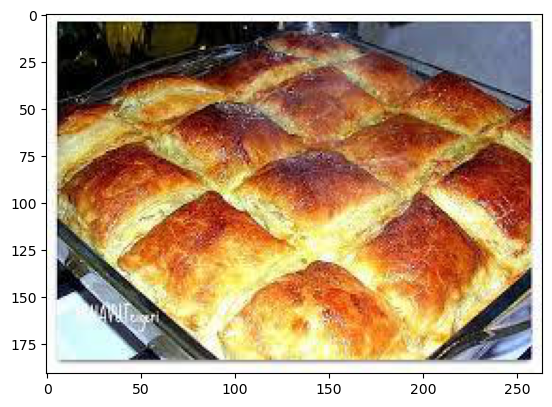

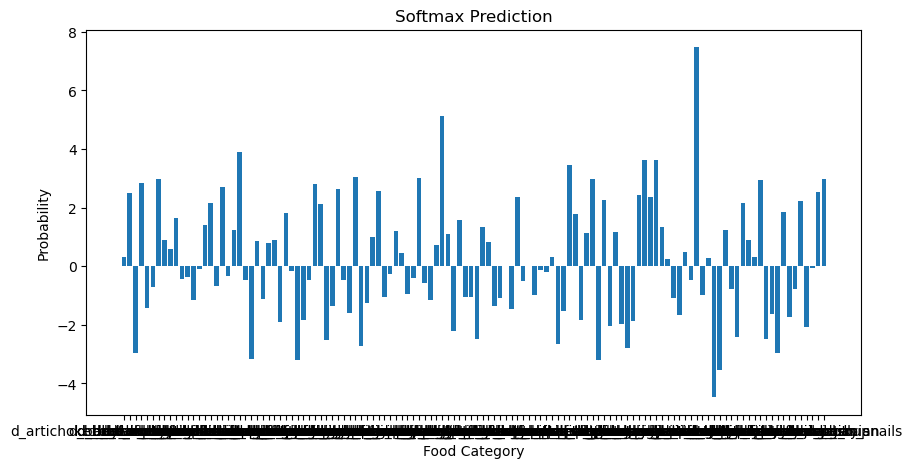

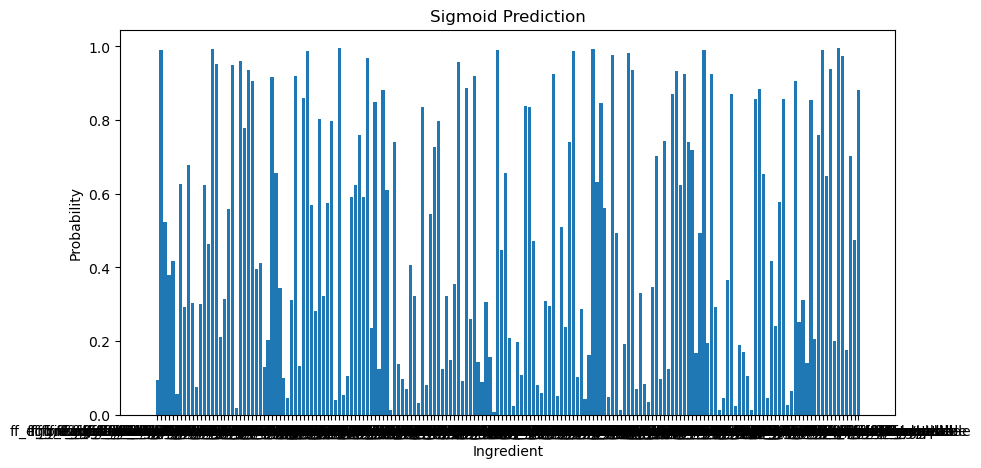

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load a test image
img_path = '43.jpg'
img = Image.open(img_path).convert('RGB')
plt.imshow(img)

# Resize image and convert to tensor
transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])
img = transform(img)
img = img.unsqueeze(0)

# Get model predictions
model.eval()
with torch.no_grad():
    sl_preds, ml_preds = model(img.to(device))
    
    # Show prediction percentages          
    print("Softmax Prediction:")
    for i, sl_pred in enumerate(sl_preds[0]): 
        pred_pct = round(max(min(sl_pred.item()*100, 100), 0), 2)
        print(f"{classes[i]}: {pred_pct}%")

    print("Sigmoid Prediction:")
    for i, ml_pred in enumerate(ml_preds[0]): 
        pred_pct = round(max(min(ml_pred.item()*100, 100), 0), 2)
        print(f"{ingredients[i]}: {pred_pct}%")
        
    # Convert predictions to numpy.ndarray and move to CPU
    sl_preds = sl_preds.cpu().numpy()
    ml_preds = ml_preds.cpu().numpy()

# Plot prediction results
sl_preds = sl_preds.squeeze()
plt.figure(figsize=(10, 5))
plt.bar(classes, sl_preds)
plt.title('Softmax Prediction')
plt.xlabel('Food Category')
plt.ylabel('Probability')
plt.show()

ml_preds = ml_preds.squeeze()
plt.figure(figsize=(10, 5))
plt.bar(ingredients, ml_preds)
plt.title('Sigmoid Prediction')
plt.xlabel('Ingredient')
plt.ylabel('Probability')
plt.show()
